In [1]:
import numpy as np
import matplotlib.pyplot as plt
from time import time

# Toy Example

$$ S + I \to I + I, c_1x_Sx_I $$
$$ S \to I, c_2x_S $$
with parameters $c_1 = 0.008, c_2=0.1.$

For $\tau$-leaping we use $\tau = 0.3$ for $T = 50$.

## Tau Leaping

In [7]:
def rate1(X):
    rate = X[0]*X[1]
    if rate > 0:
        return rate
    else:
        return 0

def rate2(X):
    rate = X[0]
    if rate > 0:
        return rate
    else:
        return 0

    
def tau_leaping(S, c, X0, T, tau):
    """
    S: Stoichiometry matrix. Each row represents a reaction, and each column represents a species.
    c: Array of reaction rates.
    X0: Initial state.
    T: Total time.
    tau: Leap size.
    """
    t = 0.0
    X = []
    X.append(X0)
    i = 0

    for j in range(T):
        a = c*np.array([rate1(X[i]), rate2(X[i])])  # Propensity function
        K = np.random.poisson(a*tau)  # Number of reactions
        X_new = X[i] + np.dot(K, S)  # Update the state
        X.append(X_new)
        t += tau  # Update the time
        i = i+1

        # Check for negative populations
        if np.any(X[i] < 0):
            raise ValueError("Negative population")

    return X

# Example usage:
S = np.array([[-1, 1], [-1, 1]])  # Stoichiometry matrix
c = np.array([0.008, 0.1])  # Reaction rates
X0 = np.array([90, 10])  # Initial state
T = 9  # Total time
tau = 0.1  # Leap size

n_runs = 1000
runs = []

for _ in range(n_runs):
    X = tau_leaping(S, c, X0, T, tau)
    runs.append(X)

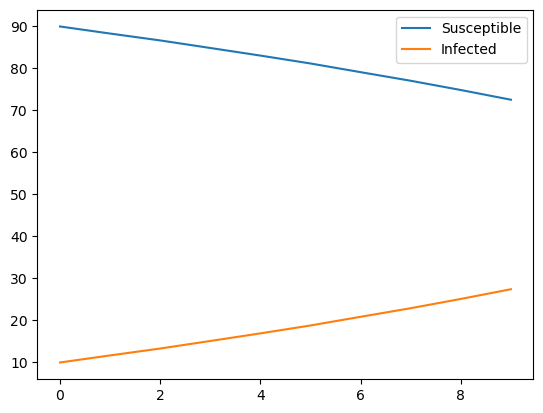

In [8]:
Xs = np.mean(np.array(runs)[:,:,0], axis=0)
Xi = np.mean(np.array(runs)[:,:,1], axis=0)

plt.plot(range(len(X)), Xs, label='Susceptible')
plt.plot(range(len(X)), Xi, label='Infected')
plt.legend()

## SOGA - Gaussian Approx.

In [9]:

from sogaPreprocessor import *
from producecfg import *
from libSOGA import *

compiledFile=compile2SOGA('../programs/SOGA/SSA/SI.soga')
cfg = produce_cfg(compiledFile)
start = time()
output_dist = start_SOGA(cfg)
end = time()

print('Computed in {}s'.format(np.round(end-start,3)))

Computed in 0.156s


In [10]:
xs = np.zeros(T+1)
xi = np.zeros(T+1)
stds = np.zeros(T+1)
stdi = np.zeros(T+1)

for i in range(T+1):
    idxs = output_dist.var_list.index('susceptible[{}]'.format(i))
    idxi = output_dist.var_list.index('infected[{}]'.format(i))
    xs[i] = output_dist.gm.mean()[idxs]
    stds[i] = np.sqrt(output_dist.gm.cov()[idxs,idxs])
    xi[i] = output_dist.gm.mean()[idxi]
    stdi[i] = np.sqrt(output_dist.gm.cov()[idxi,idxi])

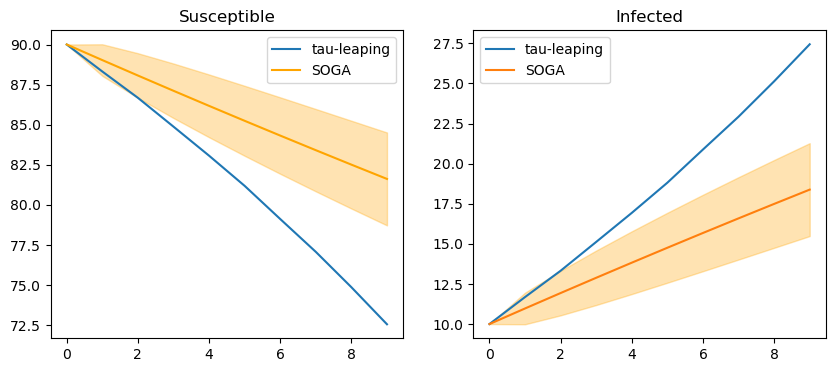

In [12]:
fig, axs = plt.subplots(1,2, figsize=(10,4))

axs[0].plot(range(len(X)), Xs, label='tau-leaping')
axs[0].plot(range(T+1), xs, label='SOGA', color='orange')
axs[0].fill_between(range(T+1), xs-stds, xs+stds ,alpha=0.3, color='orange')
axs[0].set_title('Susceptible')
axs[0].legend()

axs[1].plot(range(len(X)), Xi, label='tau-leaping')
axs[1].plot(range(T+1), xi, label='SOGA')
axs[1].fill_between(range(T+1), xi-stdi, xi+stdi ,alpha=0.3, color='orange')
axs[1].set_title('Infected')
axs[1].legend()

### Perchè non funziona

Sembra che la probabilità di avere zero reazione sia sottostimata: quello sotto è una delle approssimazioni che viene fatta nel programma. Dovrebbe migliorare molto usando le misture

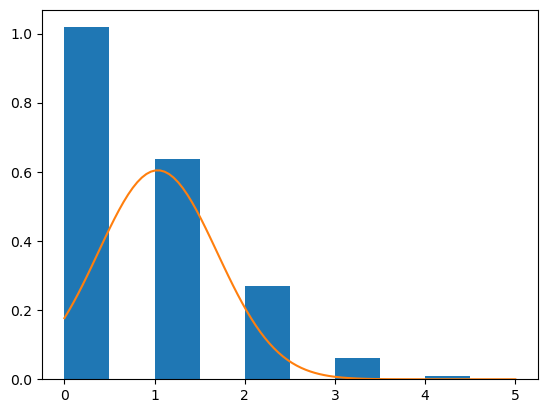

In [13]:
from scipy.stats import poisson, norm, truncnorm

mu_pois = 0.7402125879800838
sigma_pois = np.sqrt(0.03999107210133827)
mu = 0.7402125879800838
sigma = np.sqrt(0.7402125879800838)

mu_trunc, sigma_trunc = truncnorm.stats(-mu/sigma, np.inf, mu, sigma)
sigma_trunc = np.sqrt(sigma_trunc)

samples = []
for _ in range(1000):
    rate = norm.rvs(mu_pois, sigma_pois)
    samples.append(poisson.rvs(rate))
    
x = np.linspace(0,5,100)
_=plt.hist(samples, density=True)
_=plt.plot(x, norm.pdf(x,mu_trunc,sigma_trunc))

## Problema 2

Quando usiamo l'encoding discreto dovremmo "quasi" essere esatti, invece commettiamo comunque un errore alto (non possiamo provare per tempi più lunghi perchè va in memory error)

Computed in 0.025s


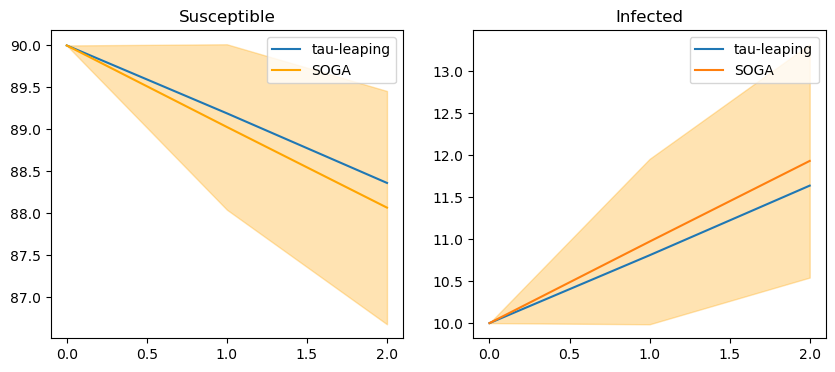

In [20]:
# Tau-leaping
S = np.array([[-1, 1], [-1, 1]])  # Stoichiometry matrix
c = np.array([0.008, 0.1])  # Reaction rates
X0 = np.array([90, 10])  # Initial state
T = 2  # Total time
tau = 0.05  # Leap size

n_runs = 1000
runs = []

for _ in range(n_runs):
    X = tau_leaping(S, c, X0, T, tau)
    runs.append(X)
    
Xs = np.mean(np.array(runs)[:,:,0], axis=0)
Xi = np.mean(np.array(runs)[:,:,1], axis=0)
    
# SOGA

compiledFile=compile2SOGA('../programs/SOGA/SSA/SIdisc.soga')
cfg = produce_cfg(compiledFile)
start = time()
output_dist = start_SOGA(cfg)
end = time()

print('Computed in {}s'.format(np.round(end-start,3)))

xs = np.zeros(T+1)
xi = np.zeros(T+1)
stds = np.zeros(T+1)
stdi = np.zeros(T+1)

for i in range(T+1):
    idxs = output_dist.var_list.index('susceptible[{}]'.format(i))
    idxi = output_dist.var_list.index('infected[{}]'.format(i))
    xs[i] = output_dist.gm.mean()[idxs]
    stds[i] = np.sqrt(output_dist.gm.cov()[idxs,idxs])
    xi[i] = output_dist.gm.mean()[idxi]
    stdi[i] = np.sqrt(output_dist.gm.cov()[idxi,idxi])

# Plot

fig, axs = plt.subplots(1,2, figsize=(10,4))

axs[0].plot(range(len(X)), Xs, label='tau-leaping')
axs[0].plot(range(T+1), xs, label='SOGA', color='orange')
axs[0].fill_between(range(T+1), xs-stds, xs+stds ,alpha=0.3, color='orange')
axs[0].set_title('Susceptible')
axs[0].legend()

axs[1].plot(range(len(X)), Xi, label='tau-leaping')
axs[1].plot(range(T+1), xi, label='SOGA')
axs[1].fill_between(range(T+1), xi-stdi, xi+stdi ,alpha=0.3, color='orange')
axs[1].set_title('Infected')
axs[1].legend()